# Variational Autoencoder (VAE)
Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this seminar we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)

# Load the data
Not a very interesting step; read in the data from the Labeled Faces in the Wild dataset, and make them TensorFlow-compatible

In [2]:
from lfw_dataset import fetch_lfw_dataset

base_path = '/Users/thomas/mlhep/showmlhep/vae'

data, attrs = fetch_lfw_dataset(dimx=36, dimy=36,
                                images_name = base_path + "/lfw-deepfunneled",
                                attrs_name =  base_path + "/lfw_attributes.txt")
data = data.astype(np.float32) / 255.

Short inspection of what is actually in the dataset:

In [3]:
def plot_gallery(images, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.axis('off')

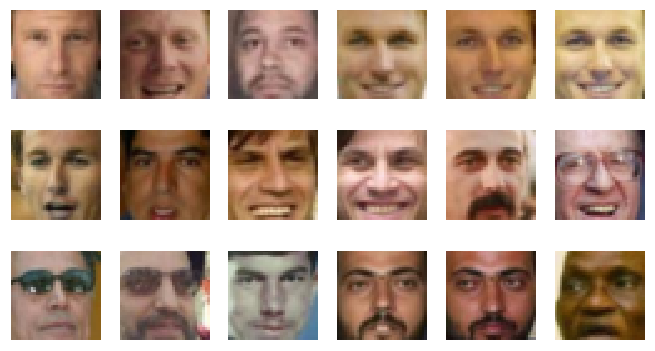

In [4]:
plot_gallery(data)

In [5]:
import tensorflow as tf
def get_tf_dataset(dataset, batch_size):
    """
    Produces an infinite stram of Tensorflow batches from a numpy dataset. The dataset is shuffled every epoch.
    Args:
       dataset: np.array[n_examples, ...]
       batch_size: int, batch size of the results
    Reuturns:
       Tensor, containing the next batch
    """
    if isinstance(dataset, tf.Tensor):
        N_EXAMPLES = dataset.shape[0]
    else:
        N_EXAMPLES = dataset[0].shape[0]
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

# Variational Autoencoder
Now let's define the models in `keras`.

We're going to need 2:
- A neural network for the *encoder*
- A neural network for the *decoder*

In [6]:
import keras
from keras.models import Sequential, Model
from keras import layers as L

Using TensorFlow backend.


In [7]:
# Dimensions of the image: 36 pixels x 36 pixels x 3 colors (rgb)
IMG_SHAPE = data.shape[1:]

# Dimensions of the *encoded state*: We choose 128 dimensions
CODE_SIZE = 128

In [8]:
encoder_activation = tf.nn.softplus

# Define the encoder to have an elegant pyramidal structure
# It first maps images into one pixel with many channels
# Then flattens and uses a dense layer to get the CODE_SIZE outputs
FILTERS_N0 = 32
encoder = Sequential(name="Encoder")
encoder.add(L.InputLayer(IMG_SHAPE))
encoder.add(L.Conv2D(FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(int(1.5*FILTERS_N0), kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Conv2D(2*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(3*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Conv2D(4*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.Conv2D(6*FILTERS_N0, kernel_size=3, activation=encoder_activation))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Flatten())

# Having created a sequential model, we add two layers on top of its output
# Pay attention to the "Connected to" column in the summary
encoder_mu = L.Dense(CODE_SIZE, name="encoder_mu", activation=keras.activations.linear)(encoder.output)
encoder_log_sigma = L.Dense(CODE_SIZE, name="encoder_log_sigma", activation=keras.activations.linear)(encoder.output)

# Combines the sequential model and two layers into an two-headed model
image_to_mu_sigma_model = keras.Model(
    inputs=encoder.input,
    outputs=[encoder_mu, encoder_log_sigma]
    )

print(image_to_mu_sigma_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36, 36, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 48)   13872       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 48)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
# Create a decoder. It's a sequential model accepting a 1D vector of
# length CODE_SIZE inputs and outputting an image
# You may want to use a combination of Deconv2D, UpSampling2D
# An elegant solution is "invert" the encoder, switching
# Conv2D->Deconv2D MaxPool2D->UpSampling2D and reversing the layer order

def get_inverse_conv_layer_double(input, filtersno_1, filtersno_2):
    upsampling_1 = L.UpSampling2D(size=(2,2))(input)
    deconv_1a = L.Deconv2D(filtersno_1, kernel_size=3, activation=encoder_activation)(upsampling_1)
    deconv_1b = L.Deconv2D(filtersno_2, kernel_size=3, activation=encoder_activation)(deconv_1a)
    return deconv_1b

input = L.Input(shape=(CODE_SIZE,))

unflatten = L.Reshape(target_shape=(1, 1, CODE_SIZE))(input)

layer_1 = get_inverse_conv_layer_double(unflatten, 6*FILTERS_N0, 4*FILTERS_N0)
layer_2 = get_inverse_conv_layer_double(layer_1, 3*FILTERS_N0, 2*FILTERS_N0)
layer_3 = get_inverse_conv_layer_double(layer_2, 3, 3)

decoder = Model(input=input, outputs=[layer_3], name='decoder')

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 192)         221376    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 6, 6, 128)         221312    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 96)        110688    
__________

/Users/thomas/mlhep/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., name="decoder", inputs=Tensor("in...)`


# Start training

In [ ]:
TRAIN_BATCH_SIZE = 128
train_data_tf, train_attrs_tf = get_tf_dataset(
    (data.astype(np.float32), attrs.values.astype(np.float32)), TRAIN_BATCH_SIZE)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=C + \sum_{i=1}^{dimX} (x_i - f_i)^2 / h^2$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [ ]:
# The Variational part of VAE. For the training images, get mean and log(std)
train_mu, train_log_sigma = image_to_mu_sigma_model(train_data_tf)

print(train_mu)

In [ ]:
# For convenience
train_sigma = tf.exp(train_log_sigma)

# Sample from normal distribution (tf.random.normal)
sampled_noise = tf.random_normal(shape=(TRAIN_BATCH_SIZE,CODE_SIZE))

# Scale and shift the sampled values
modelled_noise = train_mu + sampled_noise * train_sigma

In [ ]:
decoded_train = decoder(modelled_noise)

print(decoded_train)

In [ ]:
# We average both over examples and dimensions to make
# the losses the same order of magnitude.
# It would have been closer to equations to sum
# over dimensions and average over examples.
# The approaches are equal up to a constant,
# which gets adjusted in the formula for the total loss

mse_loss = tf.losses.mean_squared_error(
    train_data_tf,
    decoded_train
    )

# Kullback-Leibler divergence
kl_loss = -0.5 * tf.reduce_sum(
    1. + 2.*train_log_sigma - tf.square(train_mu) - tf.square(train_sigma)
    )

# Coefficients here are, unfortunately, heuristics
# If your model outputs distorted faces, you may want to increase KL_LOSS_COEFF
# If your model output lacks diversity, you may want to decrease KL_LOSS_COEFF
# KL_LOSS_COEFF = 1e-3

KL_LOSS_COEFF = 1e-6
total_loss = mse_loss + KL_LOSS_COEFF * kl_loss

In [ ]:
generation_batch_size = tf.placeholder_with_default(3, [], name="generation_batch_size")
generated_image = decoder(tf.random_normal([generation_batch_size, CODE_SIZE]))

In [ ]:
iteration_tf = tf.Variable(0)
optimization_op = tf.train.AdamOptimizer(1e-3).minimize(
    total_loss,
    var_list=image_to_mu_sigma_model.trainable_weights + decoder.trainable_weights,
    global_step=iteration_tf
    )

learning_summary = tf.summary.merge([
    tf.summary.scalar("kl_loss", kl_loss),
    tf.summary.scalar("mse_loss", mse_loss),
    tf.summary.scalar("total_loss", total_loss),
    tf.summary.image("generated_image", generated_image)
])

In [ ]:
config_tf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config_tf)
sess.run(tf.global_variables_initializer())

from tqdm import tnrange
import os

LOGDIR = os.path.join("/Users/thomas/mlhep/showmlhep/tensorflow-logs")
MODEL_NAME = "VAE_v1"
TOTAL_ITERATIONS = int(1e3)

train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
train_writer.add_graph(tf.get_default_graph())

for iteration in tnrange(TOTAL_ITERATIONS):
    summary, _ = sess.run([learning_summary, optimization_op])
    train_writer.add_summary(summary, iteration)

# Actually just load the weights from the GPU training

INFO:tensorflow:Restoring parameters from /Users/thomas/mlhep/showmlhep/vae/gpu_ckpt/vae_gpu_2.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


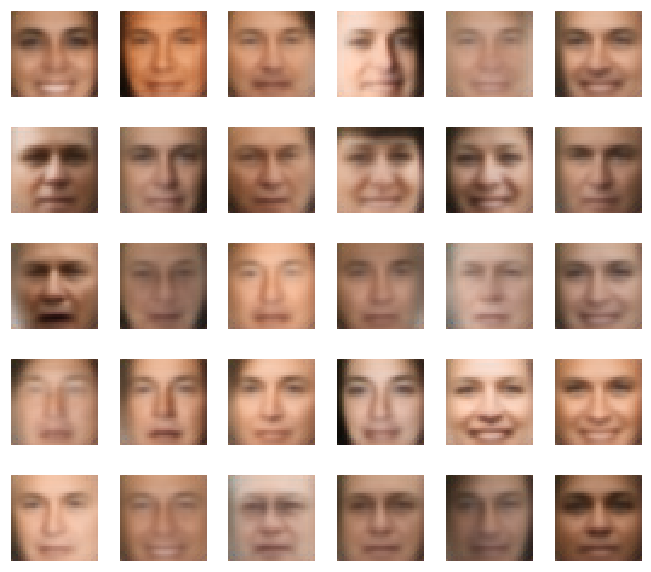

In [10]:
new_saver = tf.train.Saver()
with tf.Session() as new_sess:
    new_saver.restore(
        new_sess,
        '/Users/thomas/mlhep/showmlhep/vae/gpu_ckpt/vae_gpu_2.ckpt'
        )
    numpy_images = new_sess.run(decoder(tf.random_normal([5*6, CODE_SIZE])))
    plot_gallery(numpy_images, n_row=5, n_col=6)